In [1]:
from ase.io.trajectory import Trajectory
from ocpmodels.preprocessing import AtomsToGraphs
from ocpmodels.datasets import LmdbDataset as LD
from ase.io import read 
import yaml
import lmdb
import os
import ase
import pickle
import numpy as np
import torch
from tqdm import tqdm
import pandas as pd
from multiprocessing import Pool
import matplotlib.pyplot as plt
from coordination_calculator import SurfaceAnalyzer

## create lmdbs for the total energy of both the slab and the adslabs

In [2]:
## load the mappings stored from previous experiments
with open('hif_vasp_mappings.pkl', 'rb') as read_file:
    hif_vasp_mappings = pickle.load(read_file)

In [3]:
traj_files = np.array(os.listdir("vasp_traj_files/slabs") + os.listdir("vasp_traj_files/adslabs"))
a2g = AtomsToGraphs(
    max_neigh=50,
    radius=6,
    r_energy=False,    # False for test data
    r_forces=False,    # False for test data
    r_distances=False,
    r_fixed=True,
)

train_db = lmdb.open(
    "lmdbs/train/hif_dft.lmdb",
    map_size=1099511627776 * 2,
    subdir=False,
    meminit=False,
    map_async=True,
)
val_db = lmdb.open(
    "lmdbs/val/hif_dft.lmdb",
    map_size=1099511627776 * 2,
    subdir=False,
    meminit=False,
    map_async=True,
)

In [4]:
from sklearn.model_selection import train_test_split
ids = np.arange(0,len(traj_files)) 
train_ids, val_ids = train_test_split(ids, test_size=0.2, random_state=0)

In [5]:
# for split in ["train", "val"]:
#     idx = 0
#     for traj_file in tqdm(traj_files[eval(f"{split}_ids")]):

#         sid = int(traj_file.split(".")[0])
#         if hif_vasp_mappings[sid]["adsorbate"]==None:
#             # get the atoms obj
#             atoms_list = ase.io.read(f"vasp_traj_files/slabs/{traj_file}", ":") 
#             tags = np.ones(len(atoms_list[0]))
#         else:
#             atoms_list = ase.io.read(f"vasp_traj_files/adslabs/{traj_file}", ":") 
#             tags = np.ones(len(atoms_list[0]))
#             # set tag 2 to the adsortbate
#             tags[-1] = 2
            
        
#         for fid, atoms in enumerate(atoms_list):
#             image = a2g.convert(atoms)
#             image.y = atoms.get_potential_energy()
#             image.force  = torch.tensor(atoms.get_forces())
#             image.sid = torch.LongTensor([sid]) 
#             image.fid = torch.LongTensor([fid])
#             image.tags = torch.LongTensor(tags)
#             image.oc22=1

#             # Write to LMDB
#             txn = eval(f"{split}_db").begin(write=True)
#             txn.put(f"{idx}".encode("ascii"), pickle.dumps(image, protocol=-1))
#             txn.commit()
#             eval(f"{split}_db").sync()
#             idx += 1

#     txn = eval(f"{split}_db").begin(write=True)
#     txn.put(f"length".encode("ascii"), pickle.dumps(idx, protocol=-1))
#     txn.commit()
#     eval(f"{split}_db").sync()
#     eval(f"{split}_db").close()

In [9]:
base_yaml_path = "/home/jovyan/shared-scratch/kabdelma/ocp/configs/oc22/s2ef/base_joint.yml"
base_yaml = yaml.safe_load(
        open(base_yaml_path, "r")
    )
##
# del base_yaml["dataset"]["test"]
base_yaml["dataset"]["train"]["src"] = "/home/jovyan/shared-scratch/kabdelma/high_miller_idx/lmdbs/train"
base_yaml["dataset"]["val"]["src"] = "/home/jovyan/shared-scratch/kabdelma/high_miller_idx/lmdbs/val"
base_yaml["dataset"]["test"] = {"src" : "/home/jovyan/shared-scratch/kabdelma/high_miller_idx/lmdbs/val"}
##
with open(base_yaml_path, "w") as f:
    yaml.dump(base_yaml, f, default_flow_style=False)

In [10]:
goc_oc20_oc22_yaml_path = "/home/jovyan/shared-scratch/kabdelma/ocp/configs/oc22/s2ef/gemnet-oc/gemnet_oc_oc20_oc22_degen_edges.yml"
##
goc_yaml = yaml.safe_load(
        open(goc_oc20_oc22_yaml_path,"r")
    )
goc_yaml["includes"][0] = '/home/jovyan/shared-scratch/kabdelma/ocp/configs/oc22/s2ef/base_joint.yml'
##
with open(goc_oc20_oc22_yaml_path, "w") as f:
    yaml.dump(goc_yaml, f, default_flow_style=False)

## inference 

## Without finetuning

In [22]:
val = LD({"src":"/home/jovyan/shared-scratch/kabdelma/high_miller_idx/lmdbs/val"})

sid_fid_list = []
total_energies = []
forces_list = []
num_atoms_list = []
def get_sid_fid(args):
    idx, idx_subsplit = args
    for i in tqdm(idx_subsplit):
        sid_fid_list.append(str(val[i].sid.item()) + "_" +  str(val[i].fid.item()))
        total_energies.append(val[i].y)
        forces_list.append(np.array(val[i].force))
        num_atoms_list.append(len(val[i].force))
    return total_energies, sid_fid_list, forces_list, num_atoms_list


# Create a multiprocessing Pool
NUM_WORKERS = 16
# split up the dictionary that has all the atoms objects
indices_splits = np.array_split(np.arange(0,len(val)), NUM_WORKERS)
# pool over these splits 
pool = Pool(NUM_WORKERS)     
mp_args = [(lmdb_idx, subsplit) for lmdb_idx, subsplit in enumerate(indices_splits)]

all_outputs = list(pool.imap(get_sid_fid, mp_args))

# combine the outputs from the pool
for output in all_outputs:
    total_energies += output[0]
    sid_fid_list += output[1]
    forces_list += output[2]
    num_atoms_list += output[3]

total_energies = dict(zip(sid_fid_list, total_energies))
forces_dict  = dict(zip(sid_fid_list, forces_list))
num_atoms_dict = dict(zip(sid_fid_list, num_atoms_list))


pred_path ="results/2024-06-19-13-00-48-hif_goc_inference_all_oc20_oc22_slab_adslabs/s2ef_predictions.npz"


val_id_predictions = np.load(pred_path)
energies = val_id_predictions["energy"]
forces_pred = np.split(val_id_predictions["forces"], val_id_predictions["chunk_idx"])
ids = val_id_predictions["ids"]


###
total_energy_list = []
num_atoms_list = []
val_id_preds_goc = []
forces_maes = []
forces_mean_errors_ml_dft = []
sids = []
fids = []
def get_energies(args):
    idx, traj_subsplit = args
    for sid_fid in tqdm(traj_subsplit):
        total_energy_list.append(total_energies[sid_fid])
        num_atoms_list.append(num_atoms_dict[sid_fid])
        sids.append(int(sid_fid.split("_")[0]))
        fids.append(int(sid_fid.split("_")[1]))
        val_id_preds_goc.append(energies[np.where(ids == sid_fid)[0]][0])
        # get dft forces 
        dft_forces = forces_dict[sid_fid]
        # get ml forces 
        ml_forces = forces_pred[np.where(ids == sid_fid)[0][0]]
        ## compute the mean force errors
        # print(dft_forces.shape, ml_forces.shape)
        # forces_mean_errors_ml_dft.append(np.mean(ml_forces - dft_forces))
        # # compute maes
        # forces_maes.append(np.mean(np.abs(ml_forces - dft_forces)))

    return total_energy_list,num_atoms_list, val_id_preds_goc, sids, fids, #forces_maes, forces_mean_errors_ml_dft


# Create a multiprocessing Pool
NUM_WORKERS = 8
# split up the dictionary that has all the atoms objects
train_trajs_splits = np.array_split(np.array(sid_fid_list), NUM_WORKERS)
# pool over these splits 
pool = Pool(NUM_WORKERS)     
mp_args = [(lmdb_idx, subsplit) for lmdb_idx, subsplit in enumerate(train_trajs_splits)]

all_outputs = list(pool.imap(get_energies, mp_args))

# combine the outputs from the pool
for output in all_outputs:
    total_energy_list += output[0]
    num_atoms_list += output[1]
    val_id_preds_goc += output[2]
    sids += output[3]
    fids += output[4]
    # forces_maes += output[4]
    # forces_mean_errors_ml_dft += output[5]



df_val_id = pd.DataFrame({"sid":sids,
              "fid":fids,
              "total_energy":total_energy_list,
              "total_energy_pred":val_id_preds_goc,
                "num_atoms":num_atoms_list,
                # "forces_mae":forces_maes,
                # "forces_mean_error_ml_dft":forces_mean_errors_ml_dft
             })
df_val_id

100%|██████████| 16/16 [00:00<00:00, 182.01it/s]

100%|██████████| 16/16 [00:00<00:00, 182.86it/s]

100%|██████████| 16/16 [00:00<00:00, 177.83it/s]


100%|██████████| 16/16 [00:00<00:00, 175.14it/s]

100%|██████████| 16/16 [00:00<00:00, 181.48it/s]

100%|██████████| 32/32 [00:00<00:00, 27531.84it/s]

,sid,fid,total_energy,total_energy_pred,num_atoms
0,1916,0,-704.729500,-704.184753,225
1,1916,1,-704.730334,-704.169617,225
2,97071,0,-328.421386,-328.226227,105
3,97071,1,-328.422052,-328.227600,105
4,97071,2,-328.422481,-328.226746,105
...,...,...,...,...,...
250,22597,8,-284.863595,-285.229523,96
251,22597,9,-284.863616,-285.228973,96
252,22597,10,-284.865521,-285.241272,96
253,69343,0,-348.198398,-348.392303,113


In [24]:
df_val_id["energy_error"] = df_val_id["total_energy"] - df_val_id["total_energy_pred"]
df_val_id["energy_mae"] = np.abs(df_val_id["energy_error"])
print("Energy MAE: ", df_val_id["energy_mae"].mean())
df_val_id.sort_values("energy_mae", ascending=False)

Energy MAE:  0.19468396122303924


,sid,fid,total_energy,total_energy_pred,num_atoms,energy_error,energy_mae
52,51294,0,-290.899641,-291.512390,97,0.612749,0.612749
53,51294,1,-290.900375,-291.508392,97,0.608017,0.608017
50,21823,0,-291.443909,-292.012848,97,0.568939,0.568939
51,21823,1,-291.444833,-292.012329,97,0.567497,0.567497
1,1916,1,-704.730334,-704.169617,225,-0.560717,0.560717
...,...,...,...,...,...,...,...
203,57606,19,-218.900857,-218.897797,72,-0.003061,0.003061
140,92704,8,-225.997208,-226.000061,73,0.002853,0.002853
136,92704,4,-225.997150,-225.999725,73,0.002575,0.002575
134,92704,2,-225.997197,-225.999725,73,0.002529,0.002529


In [25]:
element = []
miller_idx = []
adsorbate = []
placement_num = []
slab_id = []
for sid in df_val_id["sid"]:
    element.append(hif_vasp_mappings[sid]["mp-id"])
    miller_idx.append(hif_vasp_mappings[sid]["miller_idx"])
    adsorbate.append(hif_vasp_mappings[sid]["adsorbate"])
    placement_num.append(hif_vasp_mappings[sid]["adsorbate_placement_num"])
    slab_id.append(hif_vasp_mappings[sid]["slab_id"])

In [26]:
## add these lists to the dataframe
df_val_id["element"] = element
df_val_id["miller_index"] = miller_idx
df_val_id["adsorbate"] = adsorbate
df_val_id["placement_num"] = placement_num
df_val_id["slab_id"] = slab_id
df_val_id

,sid,fid,total_energy,total_energy_pred,num_atoms,energy_error,energy_mae,element,miller_index,adsorbate,placement_num,slab_id
0,1916,0,-704.729500,-704.184753,225,-0.544746,0.544746,mp-30,554,*O,2.0,69092.0
1,1916,1,-704.730334,-704.169617,225,-0.560717,0.560717,mp-30,554,*O,2.0,69092.0
2,97071,0,-328.421386,-328.226227,105,-0.195159,0.195159,mp-30,643,*O,4.0,94471.0
3,97071,1,-328.422052,-328.227600,105,-0.194452,0.194452,mp-30,643,*O,4.0,94471.0
4,97071,2,-328.422481,-328.226746,105,-0.195735,0.195735,mp-30,643,*O,4.0,94471.0
...,...,...,...,...,...,...,...,...,...,...,...,...
250,22597,8,-284.863595,-285.229523,96,0.365927,0.365927,mp-30,410,None,NaN,NaN
251,22597,9,-284.863616,-285.228973,96,0.365357,0.365357,mp-30,410,None,NaN,NaN
252,22597,10,-284.865521,-285.241272,96,0.375751,0.375751,mp-30,410,None,NaN,NaN
253,69343,0,-348.198398,-348.392303,113,0.193906,0.193906,mp-30,431,*O,3.0,3718.0


In [27]:
dft_energies= []
ml_energies = []
energy_mae = []
num_atoms = []
miller_indices = []
for sid in df_val_id["sid"].unique():
    # get the energy correspodning to the largest fid 
    max_fid = df_val_id.query(f"sid=={sid}")["fid"].max()
    dft_energies.append(df_val_id.query(f"sid=={sid}&fid=={max_fid}")["total_energy"].values[0])
    num_atoms.append(df_val_id.query(f"sid=={sid}&fid=={max_fid}")["num_atoms"].values[0])
    ml_energies.append(df_val_id.query(f"sid=={sid}&fid=={max_fid}")["total_energy_pred"].values[0])
    energy_mae.append(df_val_id.query(f"sid=={sid}&fid=={max_fid}")["energy_mae"].values[0])
    miller_indices.append(df_val_id.query(f"sid=={sid}&fid=={max_fid}")["miller_index"].values[0])
# convert all lists to arrays
dft_energies = np.array(dft_energies)
ml_energies = np.array(ml_energies)
energy_mae = np.array(energy_mae)
num_atoms = np.array(num_atoms)
miller_indices = np.array(miller_indices)

MAE:  0.19468396122303924


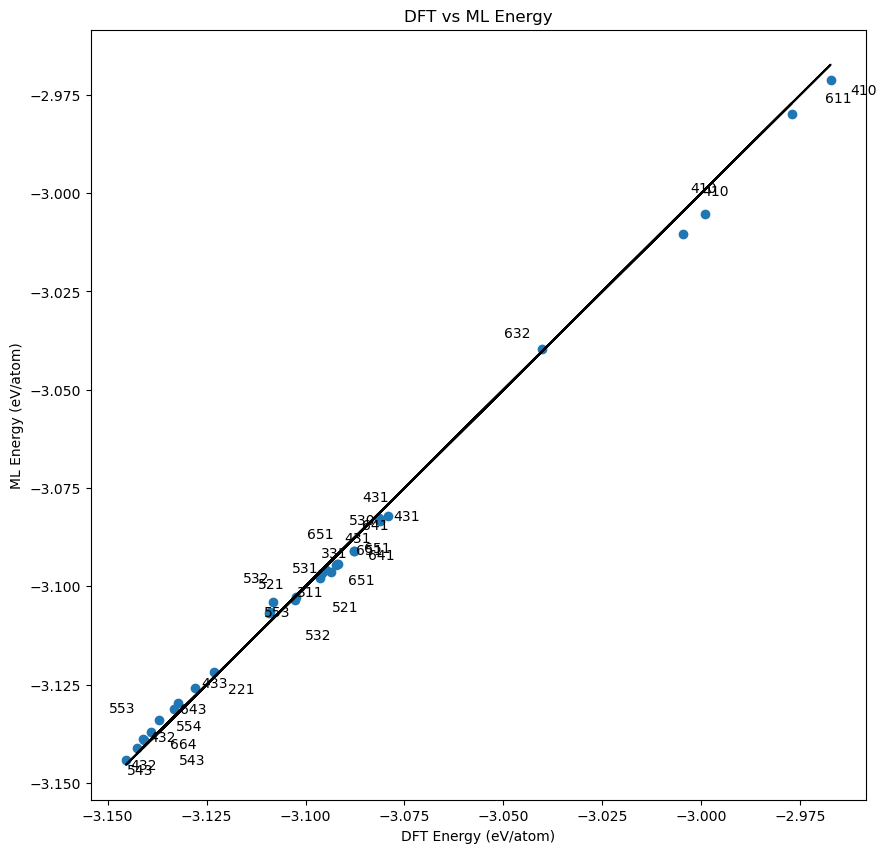

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming df_val_id, miller_indices, dft_energies, ml_energies, and num_atoms are already defined

print("MAE: ", np.mean(df_val_id["energy_mae"]))

plt.figure(figsize=(10, 10))

# Define a function to calculate the offset position
def get_offset_position(x, y, offset):
    return (x + np.random.uniform(-offset, offset), y + np.random.uniform(-offset, offset))

# Annotate with an offset to avoid overlap
offset = 0.01
for i, txt in enumerate(miller_indices):
    x = dft_energies[i] / num_atoms[i]
    y = ml_energies[i] / num_atoms[i]
    plt.annotate(txt, get_offset_position(x, y, offset))

plt.scatter(dft_energies / num_atoms, ml_energies / num_atoms)
plt.plot(dft_energies / num_atoms, dft_energies / num_atoms, "k-")
plt.xlabel("DFT Energy (eV/atom)")
plt.ylabel("ML Energy (eV/atom)")
plt.title("DFT vs ML Energy")
plt.show()


## After finetuning

In [29]:
val = LD({"src":"/home/jovyan/shared-scratch/kabdelma/high_miller_idx/lmdbs/val"})

sid_fid_list = []
total_energies = []
forces_list = []
num_atoms_list = []
def get_sid_fid(args):
    idx, idx_subsplit = args
    for i in tqdm(idx_subsplit):
        sid_fid_list.append(str(val[i].sid.item()) + "_" +  str(val[i].fid.item()))
        total_energies.append(val[i].y)
        forces_list.append(np.array(val[i].force))
        num_atoms_list.append(len(val[i].force))
    return total_energies, sid_fid_list, forces_list, num_atoms_list


# Create a multiprocessing Pool
NUM_WORKERS = 16
# split up the dictionary that has all the atoms objects
indices_splits = np.array_split(np.arange(0,len(val)), NUM_WORKERS)
# pool over these splits 
pool = Pool(NUM_WORKERS)     
mp_args = [(lmdb_idx, subsplit) for lmdb_idx, subsplit in enumerate(indices_splits)]

all_outputs = list(pool.imap(get_sid_fid, mp_args))

# combine the outputs from the pool
for output in all_outputs:
    total_energies += output[0]
    sid_fid_list += output[1]
    forces_list += output[2]
    num_atoms_list += output[3]

total_energies = dict(zip(sid_fid_list, total_energies))
forces_dict  = dict(zip(sid_fid_list, forces_list))
num_atoms_dict = dict(zip(sid_fid_list, num_atoms_list))


pred_path ="results/2024-06-19-13-11-28-hif_goc_inference_all_oc20_oc22_slab_adslabs_finetuned/s2ef_predictions.npz"


val_id_predictions = np.load(pred_path)
energies = val_id_predictions["energy"]
forces_pred = np.split(val_id_predictions["forces"], val_id_predictions["chunk_idx"])
ids = val_id_predictions["ids"]


###
total_energy_list = []
num_atoms_list = []
val_id_preds_goc = []
forces_maes = []
forces_mean_errors_ml_dft = []
sids = []
fids = []
def get_energies(args):
    idx, traj_subsplit = args
    for sid_fid in tqdm(traj_subsplit):
        total_energy_list.append(total_energies[sid_fid])
        num_atoms_list.append(num_atoms_dict[sid_fid])
        sids.append(int(sid_fid.split("_")[0]))
        fids.append(int(sid_fid.split("_")[1]))
        val_id_preds_goc.append(energies[np.where(ids == sid_fid)[0]][0])
        # get dft forces 
        dft_forces = forces_dict[sid_fid]
        # get ml forces 
        ml_forces = forces_pred[np.where(ids == sid_fid)[0][0]]
        ## compute the mean force errors
        # print(dft_forces.shape, ml_forces.shape)
        # forces_mean_errors_ml_dft.append(np.mean(ml_forces - dft_forces))
        # # compute maes
        # forces_maes.append(np.mean(np.abs(ml_forces - dft_forces)))

    return total_energy_list,num_atoms_list, val_id_preds_goc, sids, fids, #forces_maes, forces_mean_errors_ml_dft


# Create a multiprocessing Pool
NUM_WORKERS = 8
# split up the dictionary that has all the atoms objects
train_trajs_splits = np.array_split(np.array(sid_fid_list), NUM_WORKERS)
# pool over these splits 
pool = Pool(NUM_WORKERS)     
mp_args = [(lmdb_idx, subsplit) for lmdb_idx, subsplit in enumerate(train_trajs_splits)]

all_outputs = list(pool.imap(get_energies, mp_args))

# combine the outputs from the pool
for output in all_outputs:
    total_energy_list += output[0]
    num_atoms_list += output[1]
    val_id_preds_goc += output[2]
    sids += output[3]
    fids += output[4]
    # forces_maes += output[4]
    # forces_mean_errors_ml_dft += output[5]



df_val_id = pd.DataFrame({"sid":sids,
              "fid":fids,
              "total_energy":total_energy_list,
              "total_energy_pred":val_id_preds_goc,
                "num_atoms":num_atoms_list,
                # "forces_mae":forces_maes,
                # "forces_mean_error_ml_dft":forces_mean_errors_ml_dft
             })
df_val_id

100%|██████████| 16/16 [00:00<00:00, 179.75it/s]

100%|██████████| 16/16 [00:00<00:00, 180.79it/s]

100%|██████████| 16/16 [00:00<00:00, 170.36it/s]


100%|██████████| 15/15 [00:00<00:00, 178.45it/s]

100%|██████████| 32/32 [00:00<00:00, 27997.02it/s]

100%|██████████| 31/31 [00:00<00:00, 28082.81it/s]



,sid,fid,total_energy,total_energy_pred,num_atoms
0,1916,0,-704.729500,-704.928040,225
1,1916,1,-704.730334,-704.918640,225
2,97071,0,-328.421386,-328.475098,105
3,97071,1,-328.422052,-328.474213,105
4,97071,2,-328.422481,-328.473969,105
...,...,...,...,...,...
250,22597,8,-284.863595,-284.769043,96
251,22597,9,-284.863616,-284.769440,96
252,22597,10,-284.865521,-284.778625,96
253,69343,0,-348.198398,-348.318787,113


100%|██████████| 32/32 [00:00<00:00, 26405.22it/s]




In [30]:
df_val_id["energy_error"] = df_val_id["total_energy"] - df_val_id["total_energy_pred"]
df_val_id["energy_mae"] = np.abs(df_val_id["energy_error"])
print("Energy MAE: ", df_val_id["energy_mae"].mean())
df_val_id.sort_values("energy_mae", ascending=False)

Energy MAE:  0.06085224233072896


,sid,fid,total_energy,total_energy_pred,num_atoms,energy_error,energy_mae
5,18362,0,-504.461654,-504.666473,161,0.204819,0.204819
0,1916,0,-704.729500,-704.928040,225,0.198540,0.198540
6,18362,1,-504.462428,-504.653412,161,0.190984,0.190984
1,1916,1,-704.730334,-704.918640,225,0.188307,0.188307
127,17809,1,-502.837844,-503.008667,161,0.170823,0.170823
...,...,...,...,...,...,...,...
78,2167,4,-285.797902,-285.801147,96,0.003246,0.003246
153,92704,21,-226.000280,-226.002411,73,0.002131,0.002131
130,30928,2,-189.246856,-189.245117,61,-0.001739,0.001739
129,30928,1,-189.246196,-189.247894,61,0.001698,0.001698


In [31]:
element = []
miller_idx = []
adsorbate = []
placement_num = []
slab_id = []
for sid in df_val_id["sid"]:
    element.append(hif_vasp_mappings[sid]["mp-id"])
    miller_idx.append(hif_vasp_mappings[sid]["miller_idx"])
    adsorbate.append(hif_vasp_mappings[sid]["adsorbate"])
    placement_num.append(hif_vasp_mappings[sid]["adsorbate_placement_num"])
    slab_id.append(hif_vasp_mappings[sid]["slab_id"])

In [32]:
## add these lists to the dataframe
df_val_id["element"] = element
df_val_id["miller_index"] = miller_idx
df_val_id["adsorbate"] = adsorbate
df_val_id["placement_num"] = placement_num
df_val_id["slab_id"] = slab_id
df_val_id

,sid,fid,total_energy,total_energy_pred,num_atoms,energy_error,energy_mae,element,miller_index,adsorbate,placement_num,slab_id
0,1916,0,-704.729500,-704.928040,225,0.198540,0.198540,mp-30,554,*O,2.0,69092.0
1,1916,1,-704.730334,-704.918640,225,0.188307,0.188307,mp-30,554,*O,2.0,69092.0
2,97071,0,-328.421386,-328.475098,105,0.053712,0.053712,mp-30,643,*O,4.0,94471.0
3,97071,1,-328.422052,-328.474213,105,0.052161,0.052161,mp-30,643,*O,4.0,94471.0
4,97071,2,-328.422481,-328.473969,105,0.051488,0.051488,mp-30,643,*O,4.0,94471.0
...,...,...,...,...,...,...,...,...,...,...,...,...
250,22597,8,-284.863595,-284.769043,96,-0.094552,0.094552,mp-30,410,None,NaN,NaN
251,22597,9,-284.863616,-284.769440,96,-0.094177,0.094177,mp-30,410,None,NaN,NaN
252,22597,10,-284.865521,-284.778625,96,-0.086895,0.086895,mp-30,410,None,NaN,NaN
253,69343,0,-348.198398,-348.318787,113,0.120389,0.120389,mp-30,431,*O,3.0,3718.0


In [33]:
dft_energies= []
ml_energies = []
energy_mae = []
num_atoms = []
miller_indices = []
for sid in df_val_id["sid"].unique():
    # get the energy correspodning to the largest fid 
    max_fid = df_val_id.query(f"sid=={sid}")["fid"].max()
    dft_energies.append(df_val_id.query(f"sid=={sid}&fid=={max_fid}")["total_energy"].values[0])
    num_atoms.append(df_val_id.query(f"sid=={sid}&fid=={max_fid}")["num_atoms"].values[0])
    ml_energies.append(df_val_id.query(f"sid=={sid}&fid=={max_fid}")["total_energy_pred"].values[0])
    energy_mae.append(df_val_id.query(f"sid=={sid}&fid=={max_fid}")["energy_mae"].values[0])
    miller_indices.append(df_val_id.query(f"sid=={sid}&fid=={max_fid}")["miller_index"].values[0])
# convert all lists to arrays
dft_energies = np.array(dft_energies)
ml_energies = np.array(ml_energies)
energy_mae = np.array(energy_mae)
num_atoms = np.array(num_atoms)
miller_indices = np.array(miller_indices)

MAE:  0.06085224233072896


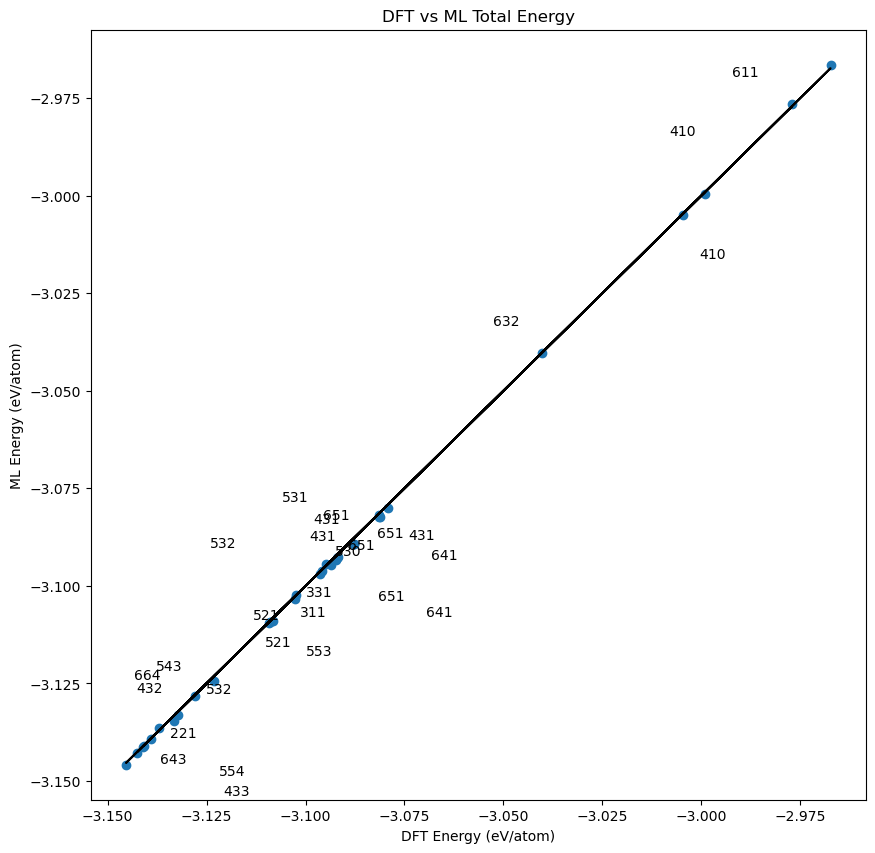

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming df_val_id, miller_indices, dft_energies, ml_energies, and num_atoms are already defined

print("MAE: ", np.mean(df_val_id["energy_mae"]))

plt.figure(figsize=(10, 10))

# Define a function to calculate the offset position
def get_offset_position(x, y, offset):
    return (x + np.random.uniform(-offset, offset), y + np.random.uniform(-offset, offset))
    # return x - offset, y + 3*offset

# Annotate with an offset to avoid overlap
offset = 0.02
for i, txt in enumerate(miller_indices):
    x = dft_energies[i] / num_atoms[i]
    y = ml_energies[i] / num_atoms[i]
    plt.annotate(txt, get_offset_position(x, y, offset))

plt.scatter(dft_energies / num_atoms, ml_energies / num_atoms)
plt.plot(dft_energies / num_atoms, dft_energies / num_atoms, "k-")
plt.xlabel("DFT Energy (eV/atom)")
plt.ylabel("ML Energy (eV/atom)")
plt.title("DFT vs ML Total Energy")
plt.show()


In [9]:
miller_indices_list = []
energy_mae_list = []
min_gcns_list = []
for miller in np.unique(df_val_id.query("element=='mp-30'")["miller_index"], return_counts=True)[0]:
    miller_indices_list.append(miller)
    energy_mae_list.append(df_val_id.query("element=='mp-30'").query(f"miller_index=='{miller}'")["energy_mae"].mean())
    num_atom = df_val_id.query("element=='mp-30'").query(f"miller_index=='{miller}'")["num_atoms"].min()
    atoms = ase.io.read("vasp_traj_files/mp_30_"+ miller+"_" + str(num_atom)+".traj") 
    sa = SurfaceAnalyzer(atoms)
    min_gcns_list.append(sa.get_surface_cn_info()["min"])

pd.DataFrame({"miller_index":miller_indices_list, 
              "energy_mae":energy_mae_list,
              "min_gcn": min_gcns_list}).sort_values("energy_mae", ascending=False)

,miller_index,energy_mae,min_gcn
3,4_3_1,4.420652,4.750000
5,5_2_1,1.453971,4.833333
4,4_4_1,1.423980,5.500000
6,5_3_0,1.399837,4.916667
7,5_4_4,1.330393,5.500000
2,4_1_0,1.053273,4.916667
1,2_1_1,0.550790,5.500000
0,1_1_0,0.528317,5.833333


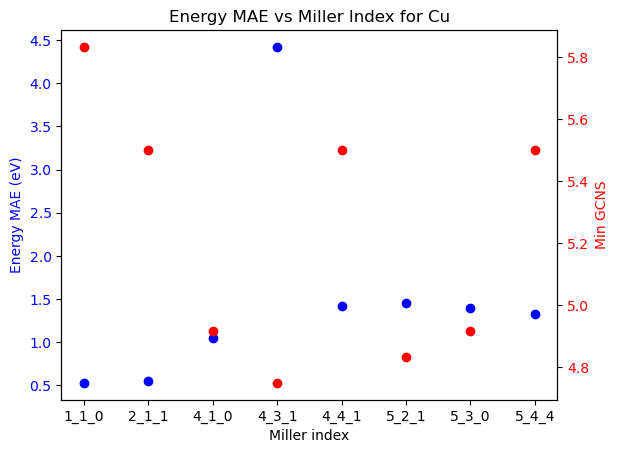

In [10]:
# Create a figure and axis
fig, ax1 = plt.subplots()

# Plot the first scatter plot on the first y-axis
ax1.scatter(miller_indices_list, energy_mae_list, color='blue', label='Energy MAE')
ax1.set_xlabel('Miller index')
ax1.set_ylabel('Energy MAE (eV)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the second scatter plot on the second y-axis
ax2.scatter(miller_indices_list, min_gcns_list, color='red', label='Min GCN value')
ax2.set_ylabel('Min GCN value', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a title
plt.title('Energy MAE vs Miller Index for Cu')

# Show the plot
plt.show()

In [169]:
# miller_indices_list = []
# energy_mae_list = []
# min_gcns_list = []
# total_energies = []
# for miller in np.unique(df_val_id.query("element=='mp-81'")["miller_index"], return_counts=True)[0]:
#     miller_indices_list.append(miller)
#     energy_mae_list.append(df_val_id.query("element=='mp-81'").query(f"miller_index=='{miller}'")["energy_mae"].mean())
#     num_atom = df_val_id.query("element=='mp-81'").query(f"miller_index=='{miller}'")["num_atoms"].min()
#     print("vasp_traj_files/mp_81_"+ miller+"_" + str(num_atom)+".traj")
#     atoms = ase.io.read("vasp_traj_files/mp_81_"+ miller+"_" + str(num_atom)+".traj", 0) 
#     sa = SurfaceAnalyzer(atoms)
#     min_gcns_list.append(sa.get_surface_cn_info()["min"])

# pd.DataFrame({"miller_index":miller_indices_list, 
#               "energy_mae":energy_mae_list,
#               "min_gcn": min_gcns_list}).sort_values("energy_mae", ascending=False)

In [222]:
# from calculate_gcn import calculate_gcn
# np.min(calculate_gcn(atoms.repeat((2,2,2))))

In [221]:
# plt.scatter(miller_indices_list, energy_mae_list)
# plt.xlabel("Miller index")
# plt.ylabel("Energy MAE (eV)")
# plt.title("Energy MAE vs Miller Index for Au")
# plt.xticks(rotation=45);

In [42]:
miller_indices_list = []
energy_mae_list = []
for miller in np.unique(df_val_id.query("element=='mp-2'")["miller_index"], return_counts=True)[0]:
    miller_indices_list.append(miller)
    energy_mae_list.append(df_val_id.query("element=='mp-2'").query(f"miller_index=='{miller}'")["energy_mae"].mean())

pd.DataFrame({"miller_index":miller_indices_list, "energy_mae":energy_mae_list}).sort_values("energy_mae", ascending=False)[:20]

,miller_index,energy_mae
3,4_3_3,7.124129
7,5_4_1,5.524590
4,5_1_1,4.597754
6,5_3_1,3.332424
2,3_2_1,2.078572
8,5_5_3,1.858671
5,5_3_0,0.697040
1,2_1_0,0.234092
0,1_0_0,0.054076
